In [12]:
import pandas as pd
import requests
import json
from pandas_datareader import data


In [13]:
ticker = 'ATER'


In [14]:
si_data = requests.get(f'https://api.nasdaq.com/api/quote/{ticker}/short-interest?assetClass=stocks',
                    headers={"Accept-Language": "en-US,en;q=0.9",
                             "Accept-Encoding": "gzip, deflate, br",
                             "User-Agent": "Java-http-client/"}).text


In [15]:
price_data = data.DataReader(ticker, 'yahoo', '2020-10-01', '2021-10-03')
price_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-09-30,8.750,7.93,8.500,8.25,169300,8.25
2020-10-01,8.440,8.02,8.250,8.33,26400,8.33
2020-10-02,8.449,7.96,8.050,8.15,57400,8.15
2020-10-05,8.520,8.26,8.280,8.43,77700,8.43
2020-10-06,8.510,8.05,8.510,8.19,128200,8.19
...,...,...,...,...,...,...
2021-09-27,13.970,12.00,13.410,12.45,38179200,12.45
2021-09-28,12.650,11.31,12.100,11.37,19380100,11.37
2021-09-29,11.470,9.67,11.100,9.96,17991300,9.96


In [16]:
data_json = json.loads(si_data)
si_df = pd.json_normalize(data_json, record_path=['data','shortInterestTable', 'rows'])
si_df['date'] = pd.to_datetime(si_df['settlementDate'])
si_df

,settlementDate,interest,avgDailyShareVolume,daysToCover,date
0,09/30/2021,"6,967,422","48,332,247",1.000000,2021-09-30
1,09/15/2021,"7,515,156","73,185,603",1.000000,2021-09-15
2,08/31/2021,"6,682,257","11,328,085",1.000000,2021-08-31
3,08/13/2021,"5,777,228","3,165,366",1.825137,2021-08-13
4,07/30/2021,"4,784,631","643,005",7.441048,2021-07-30
5,07/15/2021,"4,383,114","702,862",6.236095,2021-07-15
6,06/30/2021,"4,459,495","843,530",5.286706,2021-06-30
7,06/15/2021,"3,901,234","790,082",4.937758,2021-06-15
8,05/28/2021,"3,931,285","944,233",4.163469,2021-05-28
9,05/14/2021,"3,766,454","1,373,722",2.741788,2021-05-14


In [17]:
ibd_content = requests.get(f'https://iborrowdesk.com/api/ticker/{ticker}').text


In [18]:
ibd_json = json.loads(ibd_content)
ibd_df = pd.json_normalize(ibd_json, record_path=['daily'])
ibd_df['date'] = pd.to_datetime(ibd_df['time'])
ibd_df

,available,fee,time,date
0,1000,3.2854,2021-05-03,2021-05-03
1,30000,5.1920,2021-05-05,2021-05-05
2,15000,5.4128,2021-05-06,2021-05-06
3,7000,5.9354,2021-05-07,2021-05-07
4,30000,6.2087,2021-05-10,2021-05-10
...,...,...,...,...
92,100000,75.8789,2021-10-08,2021-10-08
93,100000,68.3694,2021-10-11,2021-10-11
94,35000,74.0072,2021-10-12,2021-10-12
95,45000,69.8626,2021-10-13,2021-10-13


<AxesSubplot:xlabel='date'>

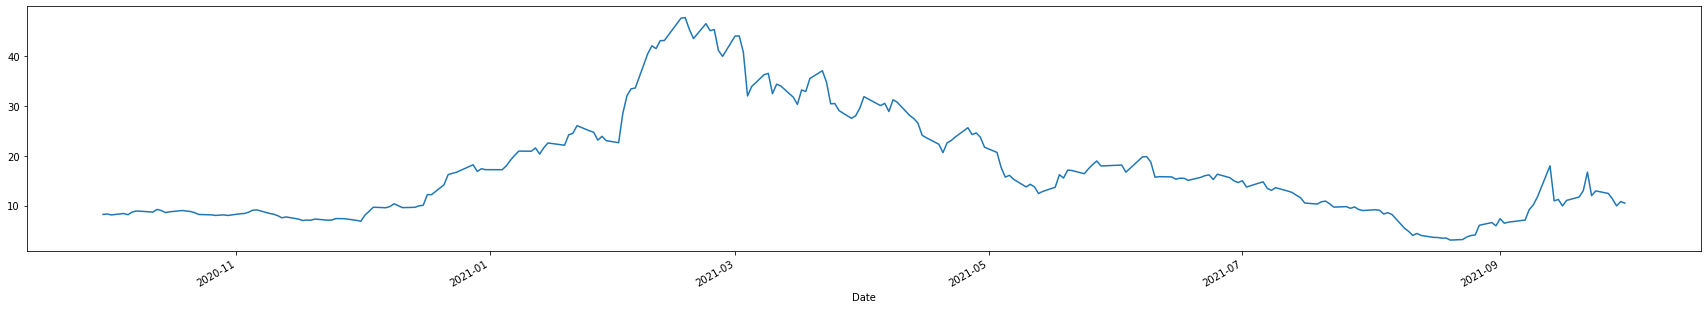

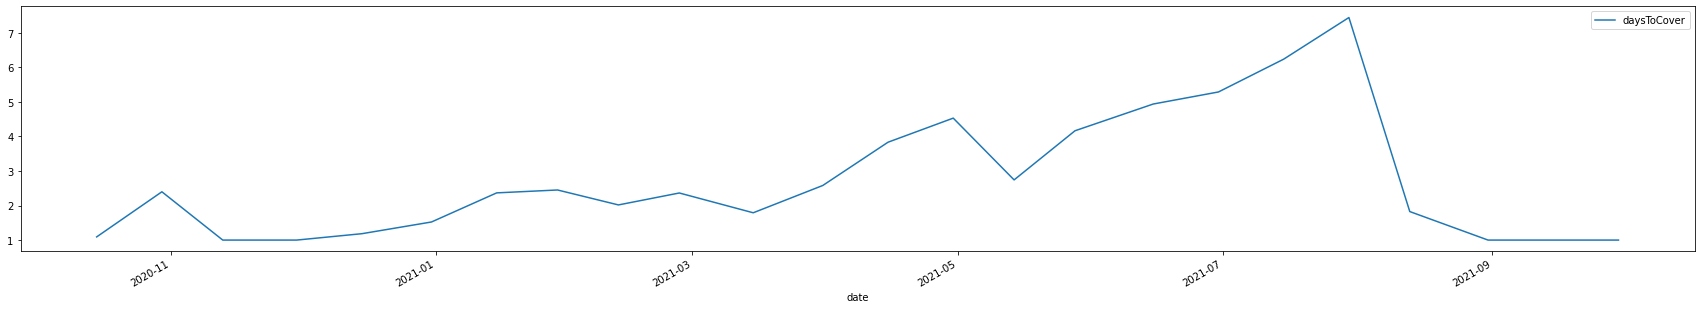

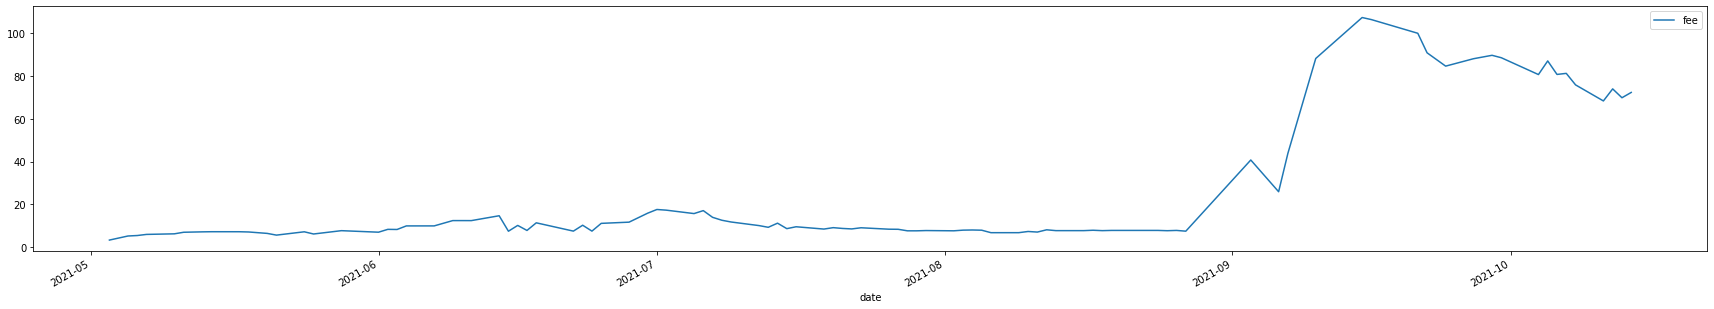

In [21]:

price_data['Adj Close'].plot(figsize=(30, 5))
si_df.plot(x='date', figsize=(30, 5))
ibd_df.plot(x='date', y='fee', figsize=(30, 5))


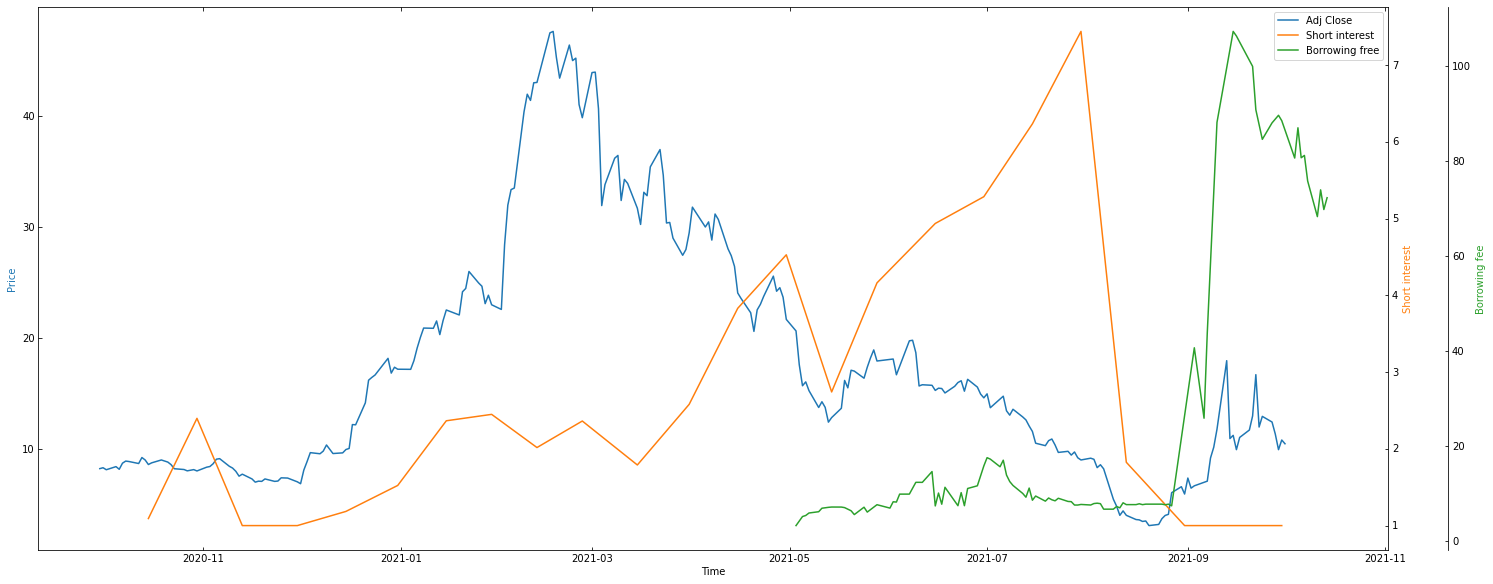

In [74]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=axisartist.Axes,figure=plt.figure(figsize=(30,10)))
plt.subplots_adjust(right=0.75)


par1 = host.twinx()
par2 = host.twinx()

par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))

par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)

p1, = host.plot(price_data.index, price_data['Adj Close'], label="Adj Close")
p2, = par1.plot(si_df['date'], si_df['daysToCover'], label="Short interest")
p3, = par2.plot(ibd_df['date'], ibd_df['fee'], label="Borrowing free")


host.set_xlabel("Time")
host.set_ylabel("Price")
par1.set_ylabel("Short interest")
par2.set_ylabel("Borrowing fee")

host.legend()

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())

plt.show()

In [ ]:
avg_borrowing_fee = ibd_df['fee'].mean()
print(f"Average borrowing fee: {avg_borrowing_fee}")
avg_si_ratio = si_df['daysToCover'].mean()
print(f"Average short interest ratio: {avg_si_ratio}")


Average borrowing fee: 0.25656398467432956
Average short interest ratio: 2.5489832173913043


In [206]:
ret_series = (1 + price_data['Adj Close'].pct_change()).cumprod() - 1
annual_return_row = ret_series.tail(1)
annual_return = annual_return_row[0]

In [207]:
# only uncomment when creating new data
# store = pd.DataFrame(None,columns=['Average borrowing fee', 'Average short interest ratio', 'Annual return'])

In [208]:
store.loc[ticker] = pd.Series([avg_borrowing_fee, avg_si_ratio, annual_return], index=store.columns)

store

,Average borrowing fee,Average short interest ratio,Annual return
AAPL,0.250622,1.176066,0.239681
MSFT,0.251285,1.848901,0.387119
GOOG,0.252664,2.089006,0.857138
AMZN,0.250222,1.323633,0.042725
FB,0.250389,1.681672,0.309698
TSLA,0.254098,1.518566,0.806997
NVDA,0.251636,1.052046,0.534586
NFLX,0.256564,2.548983,0.226226


In [209]:
store.to_csv('store.csv')

<AxesSubplot:xlabel='Average borrowing fee', ylabel='Annual return'>

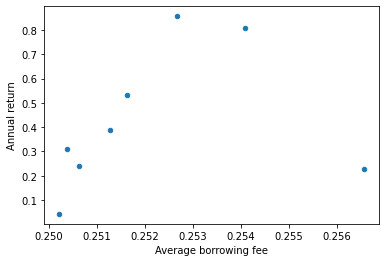

In [210]:
store.plot.scatter('Average borrowing fee', 'Annual return')

<AxesSubplot:xlabel='Average short interest ratio', ylabel='Annual return'>

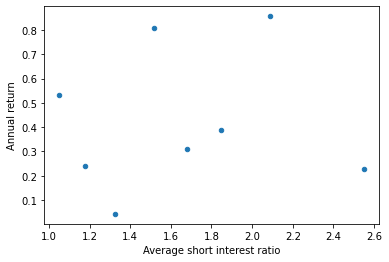

In [211]:
store.plot.scatter('Average short interest ratio', 'Annual return')